## Import Libraries


In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e9098b7522181e211aec3ed28d32d59010f1d55f997b4f6096f5a6ac316e50b3
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [2]:
!pip install streamlit pandas numpy joblib shap matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 29.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Explainability Tools
import shap
from lime.lime_tabular import LimeTabularExplainer

# Utility for saving/loading models
import joblib

# Interactive widgets
import ipywidgets as widgets

print("All necessary libraries imported successfully.")

All necessary libraries imported successfully.


## Load and Inspect Dataset


In [4]:
df = pd.read_csv('/content/heart.csv')

print("First 5 rows of the dataset:")
print(df.head())

print("\nMissing values in each column:")
print(df.isnull().sum())

print("\nDataset Info (data types and non-null counts):")
df.info()

print("\nDescriptive statistics for numerical columns:")
print(df.describe())

First 5 rows of the dataset:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Missing values in each column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR 

In [50]:
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

## Visualize Categorical Feature Distributions

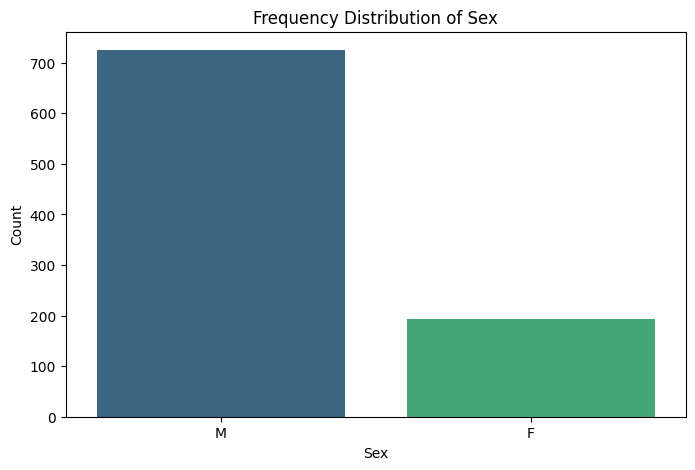

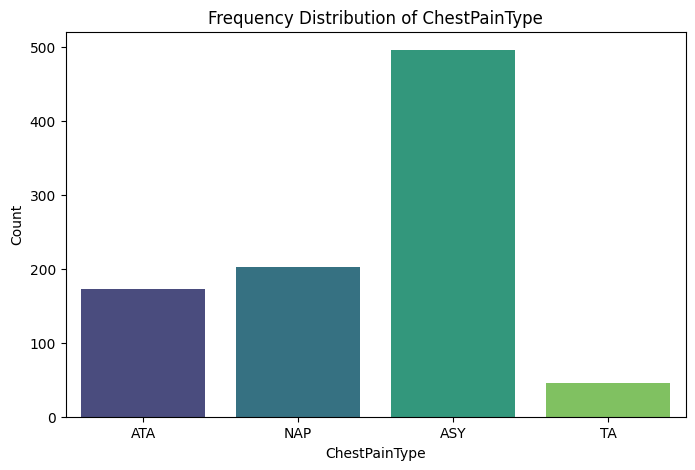

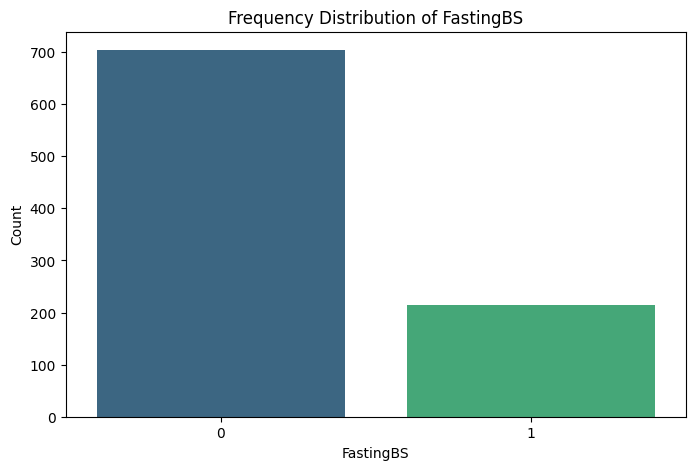

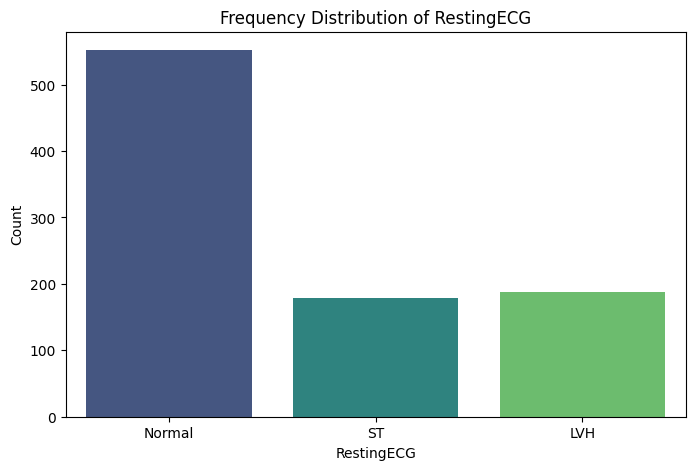

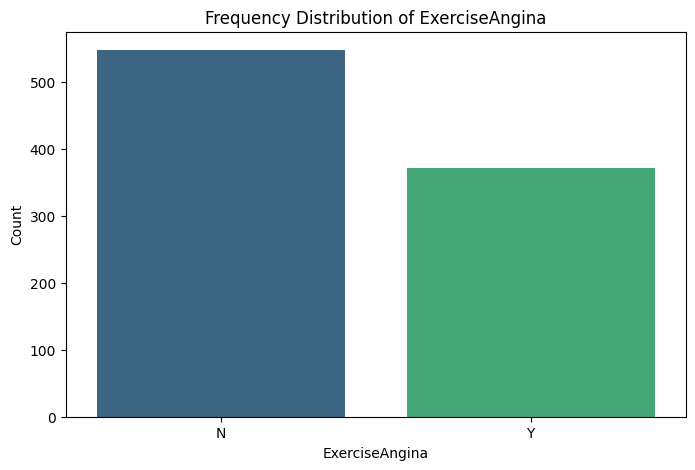

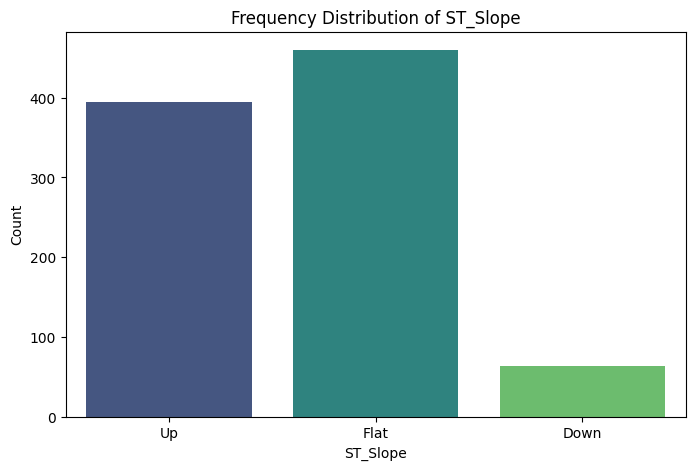

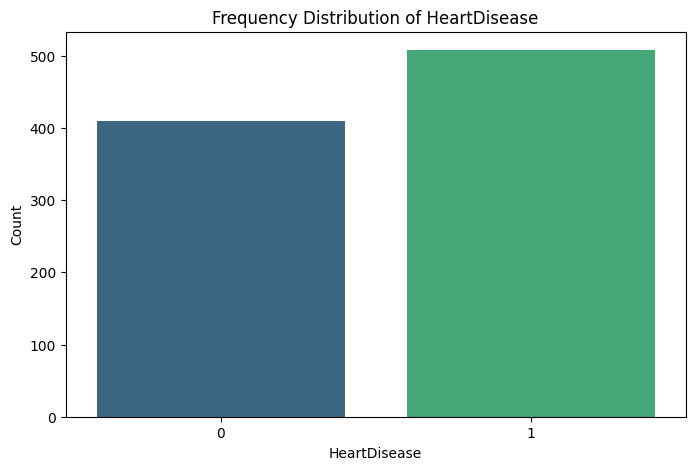

In [5]:
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

for feature in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df[feature], hue=df[feature], palette='viridis', legend=False)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'Frequency Distribution of {feature}')
    plt.show()

## Visualize Numerical Feature Distributions

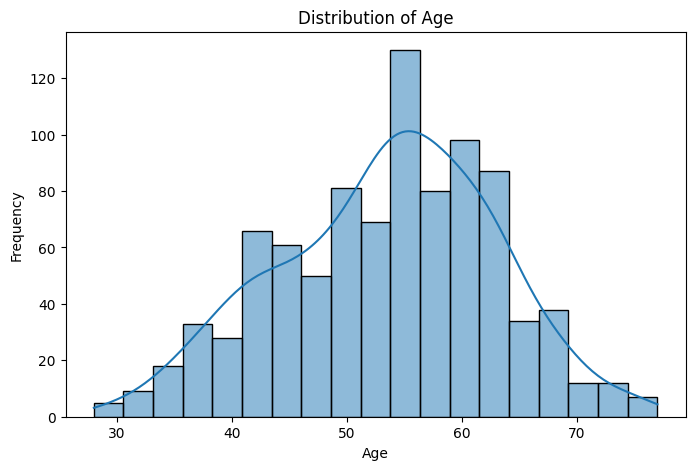

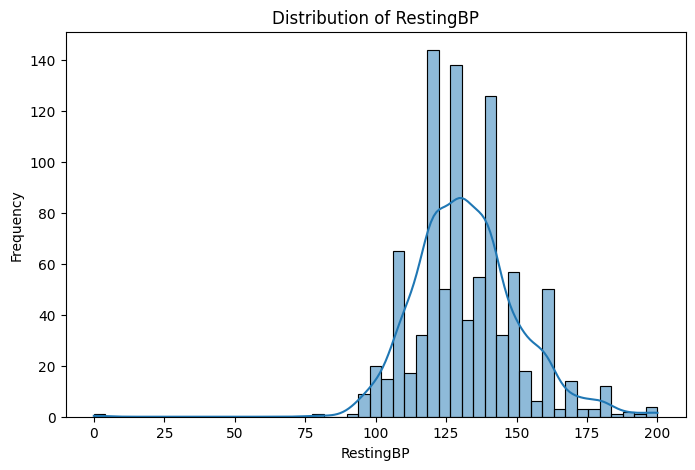

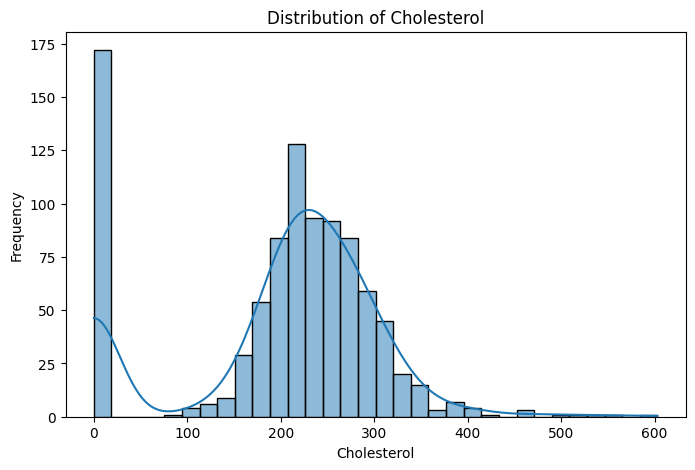

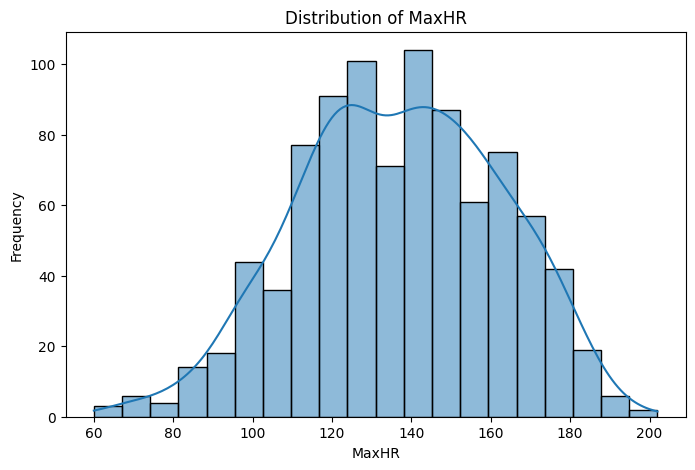

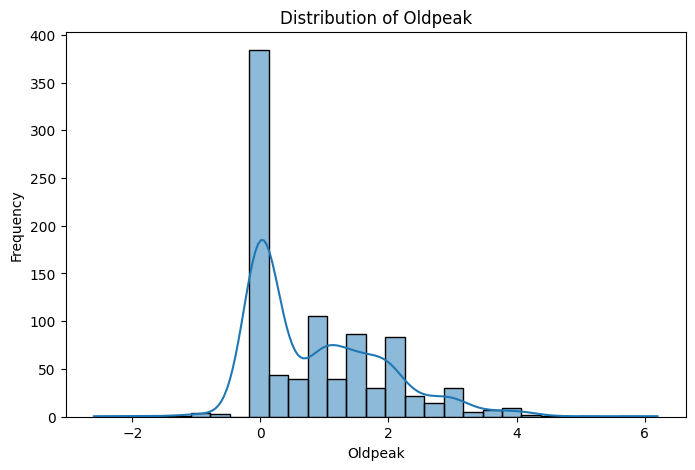

In [6]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], kde=True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature}')
    plt.show()

## Findings

Based on the **distribution analysis**, We noticed some 0's in `RestingBP` and `Cholesterol`. Since 0's for `RestingBP` and `Cholesterol` are medically impossible, these values are essentially missing data or erroneous entries. We will replace the 0 values in `RestingBP` and `Cholesterol` with their respective medians. The median is chosen because  **it is much more robust to outliers and skewed distributions**. This means it provides a more stable and representative central tendency for the data when extreme values are present.

In [7]:
# Check the number of 0s in 'RestingBP' and 'Cholesterol'
print("Number of 0s in RestingBP:", df[df['RestingBP'] == 0].shape[0])
print("Number of 0s in Cholesterol:", df[df['Cholesterol'] == 0].shape[0])

Number of 0s in RestingBP: 1
Number of 0s in Cholesterol: 172


In [8]:
# Calculate medians excluding 0s
median_restingbp = df[df['RestingBP'] != 0]['RestingBP'].median()
median_cholesterol = df[df['Cholesterol'] != 0]['Cholesterol'].median()

# Replace 0s with the calculated medians
df['RestingBP'] = df['RestingBP'].replace(0, median_restingbp)
df['Cholesterol'] = df['Cholesterol'].replace(0, median_cholesterol)

print("0 values in RestingBP replaced with median:", median_restingbp)
print("0 values in Cholesterol replaced with median:", median_cholesterol)

# Verify that there are no more 0s
print("\nNumber of 0s in RestingBP after replacement:", df[df['RestingBP'] == 0].shape[0])
print("Number of 0s in Cholesterol after replacement:", df[df['Cholesterol'] == 0].shape[0])

0 values in RestingBP replaced with median: 130.0
0 values in Cholesterol replaced with median: 237.0

Number of 0s in RestingBP after replacement: 0
Number of 0s in Cholesterol after replacement: 0


## New RestingBP and Cholesterol Distribution

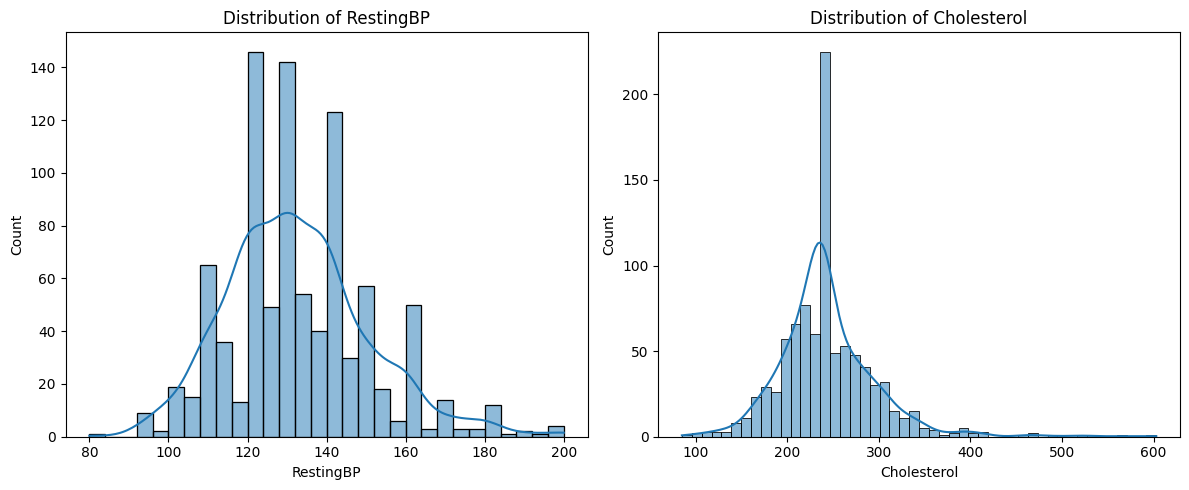

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['RestingBP'], kde=True)
plt.title('Distribution of RestingBP')

plt.subplot(1, 2, 2)
sns.histplot(df['Cholesterol'], kde=True)
plt.title('Distribution of Cholesterol')

plt.tight_layout()
plt.show()

## Preprocess Data


In [10]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Identify categorical columns and apply one-hot encoding
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numerical columns for scaling
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Initialize and apply StandardScaler to numerical columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("Data preprocessing complete.")
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print(X_train.head())

Data preprocessing complete.
Shape of X_train: (734, 15)
Shape of X_test: (184, 15)
Shape of y_train: (734,)
Shape of y_test: (184,)
          Age  RestingBP  Cholesterol     MaxHR   Oldpeak  Sex_M  \
795 -1.245067  -0.745592    -0.077534  2.284353 -0.097061   True   
25  -1.886236  -0.182505    -0.690742  1.652241 -0.836286   True   
84   0.250993   0.943670    -0.611619 -0.441628  0.087745   True   
10  -1.779375  -0.182505    -0.651181  0.229991 -0.836286  False   
344 -0.283314  -0.745592    -0.136876 -1.271274 -0.836286   True   

     ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  FastingBS_1  \
795              False               True             False         True   
25               False               True             False        False   
84               False              False             False         True   
10               False               True             False        False   
344              False              False             False         True   

 

## Initialize and Train Machine Learning Models


In [11]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained successfully.")

print("\nAll models have been initialized and trained.")

Logistic Regression trained successfully.
SVC trained successfully.
Random Forest trained successfully.
KNeighbors trained successfully.
Gaussian Naive Bayes trained successfully.

All models have been initialized and trained.


## Evaluate Models


In [12]:
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # ROC-AUC needs probability scores
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    elif hasattr(model, 'decision_function'): # For SVC when probability=True
        y_pred_proba = model.decision_function(X_test)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = 'N/A'

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }

results_df = pd.DataFrame(results).T
print("\nModel Evaluation Results:\n")
results_df.round(4)



Model Evaluation Results:



Accuracy  Precision  Recall  F1 Score  ROC-AUC
Logistic Regression     0.8587     0.9091  0.8411    0.8738   0.9247
SVC                     0.8370     0.8667  0.8505    0.8585   0.9351
Random Forest           0.8641     0.8942  0.8692    0.8815   0.9220
KNeighbors              0.8533     0.8774  0.8692    0.8732   0.9191
Gaussian Naive Bayes    0.8478     0.9158  0.8131    0.8614   0.9226

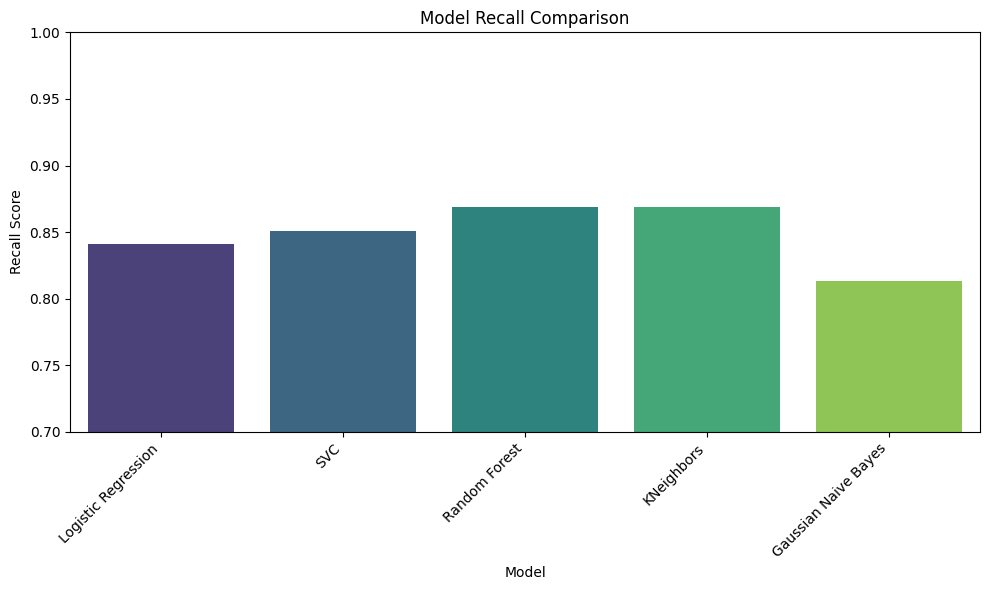

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=[result['Recall'] for result in results.values()], palette='viridis', hue=list(results.keys()), legend=False)
plt.xlabel('Model')
plt.ylabel('Recall Score')
plt.title('Model Recall Comparison')
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Select Top Models for Tuning


In [14]:
# Sort models by Recall in descending order
sorted_models = sorted(results.items(), key=lambda item: item[1]['Recall'], reverse=True)

# Select the best performing model only
best_model_name, best_model_info = sorted_models[0]

# Create a DataFrame for display
best_model_df = pd.DataFrame(
    [(best_model_name, best_model_info['Recall'])],
    columns=['Model', 'Recall Score']
)

print("Best performing model based on Recall score:")
best_model_df.round(4)


Best performing model based on Recall score:


Model  Recall Score
0  Random Forest        0.8692

## Perform Hyperparameter Tuning

In [15]:
tuned_rf = {}

# Parameter Grid for Random Forest
param_grid_rf = {
    'n_estimators': [200, 400, 600],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# GridSearchCV for hyperparameter tuning
print("Performing GridSearchCV for Random Forest...")

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Store best model info
tuned_rf['best_estimator'] = grid_search.best_estimator_
tuned_rf['best_params'] = grid_search.best_params_
tuned_rf['best_score'] = grid_search.best_score_

# Print results
print(f"\nBest parameters for Random Forest: {tuned_rf['best_params']}")
print(f"Best recall score for Random Forest (CV): {tuned_rf['best_score']:.4f}")
print("\nHyperparameter tuning complete for Random Forest.")

Performing GridSearchCV for Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters for Random Forest: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best recall score for Random Forest (CV): 0.9152

Hyperparameter tuning complete for Random Forest.


Accuracy: 0.8587
Precision: 0.8857
Recall: 0.8692
F1 Score: 0.8774
ROC AUC: 0.9212

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        77
           1       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



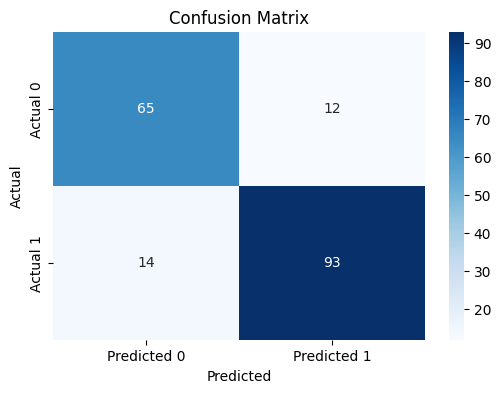

In [16]:
best_rf = tuned_rf['best_estimator']

# Predictions
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print metrics
print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))
print("ROC AUC:", round(roc_auc, 4))

# Classification report
print("\nClassification Report:")
print(class_report)

# --- Confusion Matrix Visualization ---
plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['Actual 0', 'Actual 1']
)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## Perform SHAP Explanations

In [17]:
best_model = tuned_rf['best_estimator']

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap_values_for_positive_class = shap_values[:, :, 1]
expected_value_for_positive_class = explainer.expected_value[1]

Generating SHAP Summary Plot...


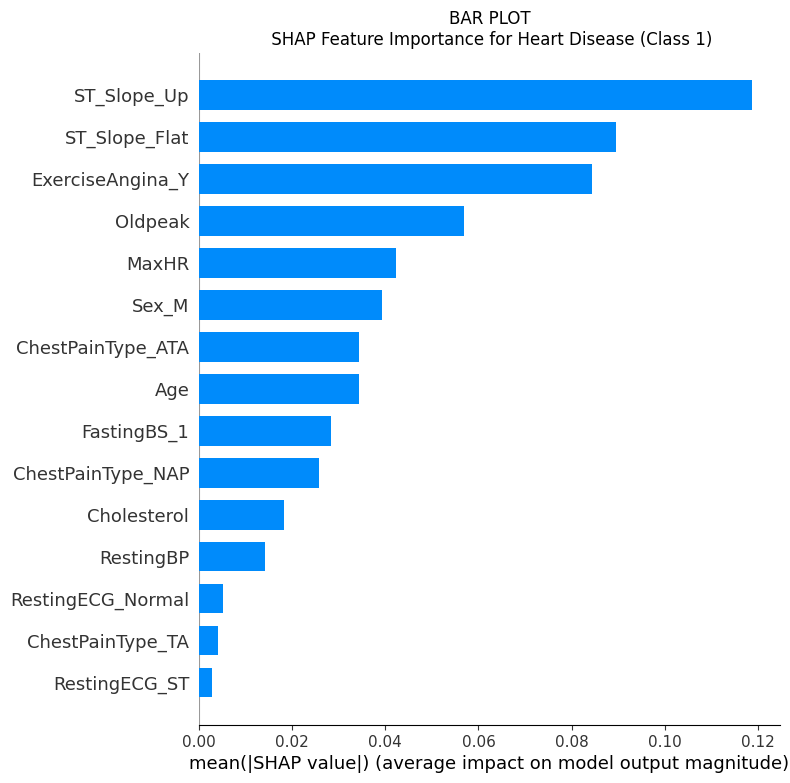

In [18]:
print("Generating SHAP Summary Plot...")
# Plot SHAP values for the positive class (Heart Disease)
shap.summary_plot(shap_values_for_positive_class, X_test, plot_type="bar", show=False)
plt.title('BAR PLOT\n SHAP Feature Importance for Heart Disease (Class 1)')
plt.show()

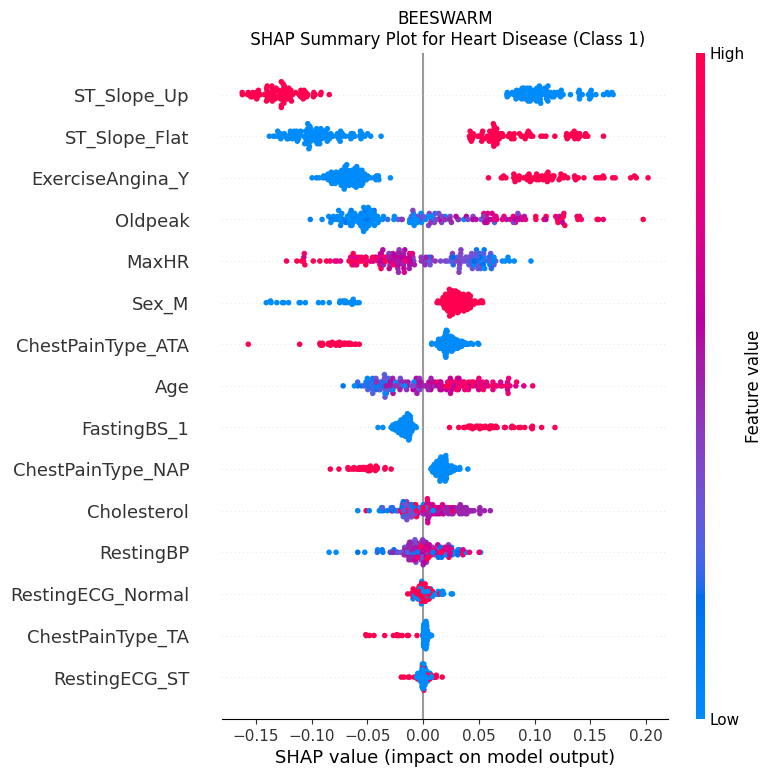

In [19]:
shap.summary_plot(shap_values_for_positive_class, X_test, show=False)
plt.title('BEESWARM\n SHAP Summary Plot for Heart Disease (Class 1)')
plt.show()

In [61]:
shap.initjs()

instance_idx = 1
X_test_instance = X_test.iloc[instance_idx]

# Force plot for the selected instance, for the positive class
shap.force_plot(expected_value_for_positive_class, shap_values_for_positive_class[instance_idx,:], X_test_instance)

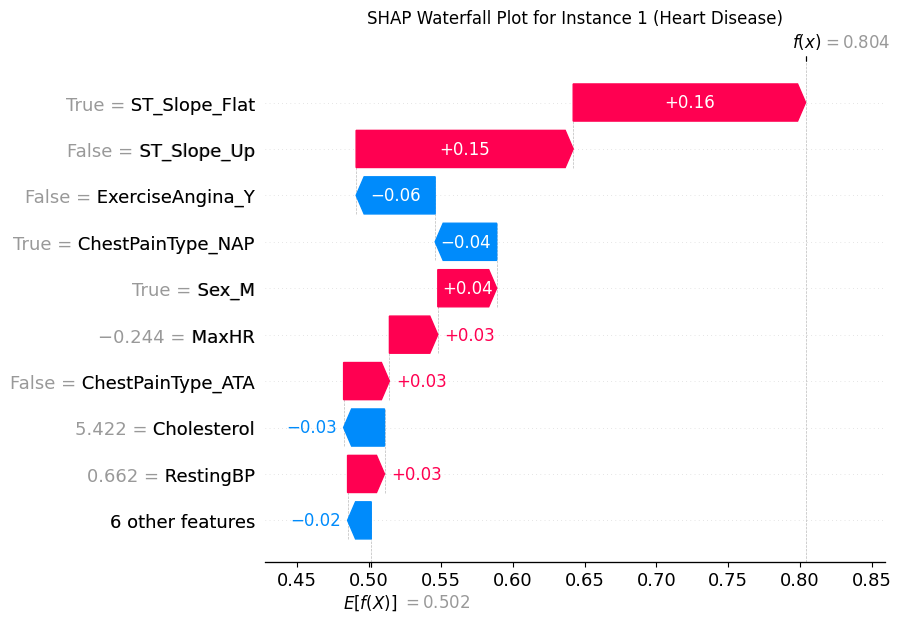

In [60]:
instance_idx = 1
X_test_instance = X_test.iloc[instance_idx]

# Waterfall plot for the selected instance, for the positive class
shap.plots.waterfall(shap.Explanation(values=shap_values_for_positive_class[instance_idx,:],
                                     base_values=expected_value_for_positive_class,
                                     data=X_test_instance.values,
                                     feature_names=X_test.columns.tolist()), show=False)
plt.title(f'SHAP Waterfall Plot for Instance {instance_idx} (Heart Disease)')
plt.show()

## Generate LIME Explanations


In [22]:
best_model = tuned_rf['best_estimator']

# Initialize LimeTabularExplainer
feature_names = X_train.columns.tolist()
class_names = ['No Disease', 'Heart Disease']

# Create a wrapper function for predict_proba to handle feature names for LIME
def predict_proba_wrapper(data):
    df_data = pd.DataFrame(data, columns=feature_names)
    return best_model.predict_proba(df_data)

explainer_lime = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Select two instances from X_test to explain
instance_1_idx = 0
instance_2_idx = 1
X_test_instance_1 = X_test.iloc[instance_1_idx]
X_test_instance_2 = X_test.iloc[instance_2_idx]

# Generate and display explanation for instance 1
exp_1 = explainer_lime.explain_instance(
    data_row=X_test_instance_1.values,
    predict_fn=predict_proba_wrapper,
    num_features=5
)
print(f"LIME Explanation for instance {instance_1_idx}:")
exp_1.show_in_notebook(show_all=False)

# Generate and display explanation for instance 2
exp_2 = explainer_lime.explain_instance(
    data_row=X_test_instance_2.values,
    predict_fn=predict_proba_wrapper,
    num_features=5
)
print(f"LIME Explanation for instance {instance_2_idx}:")
exp_2.show_in_notebook(show_all=False)

LIME Explanation for instance 0:


LIME Explanation for instance 1:


## Save Model and Scaler


In [23]:
# Save the final best performing model
final_model = tuned_rf['best_estimator']
joblib.dump(final_model, 'best_rf_heart_disease_model.joblib')
print("Final best Random Forest model saved as 'best_heart_disease_model.joblib'")
print("Best hyperparameters:", tuned_rf['best_params'])

# Save the fitted StandardScaler
joblib.dump(scaler, 'scaler.joblib')
print("Fitted StandardScaler saved as 'scaler.joblib'")

print("Model and scaler saved successfully for future use.")


Final best Random Forest model saved as 'best_heart_disease_model.joblib'
Best hyperparameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fitted StandardScaler saved as 'scaler.joblib'
Model and scaler saved successfully for future use.


## Create Interactive Prediction Form

In [48]:
import joblib
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np

# Load the saved model and scaler
final_model = joblib.load('best_rf_heart_disease_model.joblib')
scaler = joblib.load('scaler.joblib')

# Define original feature columns, separated by type as per preprocessing
original_categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']
original_numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Define widgets for each input feature
# Numerical inputs as Text widgets with default values
age_widget = widgets.Text(value='54', description='Age:')
restingbp_widget = widgets.Text(value='130', description='RestingBP:')
cholesterol_widget = widgets.Text(value='223', description='Cholesterol:')
maxhr_widget = widgets.Text(value='138', description='MaxHR:')
oldpeak_widget = widgets.Text(value='0.6', description='Oldpeak:')

# Categorical inputs as Dropdown widgets
sex_widget = widgets.Dropdown(options=['M', 'F'], value='M', description='Sex:')
chestpain_widget = widgets.Dropdown(options=['ATA', 'NAP', 'ASY', 'TA'], value='NAP', description='ChestPainType:')
fastingbs_widget = widgets.Dropdown(options=[0, 1], value=0, description='FastingBS:')
restingecg_widget = widgets.Dropdown(options=['Normal', 'ST', 'LVH'], value='Normal', description='RestingECG:')
exerciseangina_widget = widgets.Dropdown(options=['N', 'Y'], value='N', description='ExerciseAngina:')
st_slope_widget = widgets.Dropdown(options=['Up', 'Flat', 'Down'], value='Flat', description='ST_Slope:')

# Output widget to display results
output = widgets.Output()

# Define validation ranges for numerical inputs (based on df.describe())
VALIDATION_RANGES = {
    'Age': (1, 100),
    'RestingBP': (50, 250),
    'Cholesterol': (50, 700),
    'MaxHR': (50, 220),
    'Oldpeak': (-3.0, 7.0)
}

# Define the prediction function
def predict_heart_disease(Age, Sex, ChestPainType, RestingBP, Cholesterol, FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak, ST_Slope):
    with output:
        clear_output()

        # Input validation for numerical fields
        validated_inputs = {}
        errors = []

        # Age validation
        try:
            val_age = int(Age)
            if not (VALIDATION_RANGES['Age'][0] <= val_age <= VALIDATION_RANGES['Age'][1]):
                errors.append(f"Age must be between {VALIDATION_RANGES['Age'][0]} and {VALIDATION_RANGES['Age'][1]}.")
            validated_inputs['Age'] = val_age
        except ValueError:
            errors.append("Age must be an integer.")

        # RestingBP validation
        try:
            val_restingbp = int(RestingBP)
            if not (VALIDATION_RANGES['RestingBP'][0] <= val_restingbp <= VALIDATION_RANGES['RestingBP'][1]):
                errors.append(f"RestingBP must be between {VALIDATION_RANGES['RestingBP'][0]} and {VALIDATION_RANGES['RestingBP'][1]}.")
            validated_inputs['RestingBP'] = val_restingbp
        except ValueError:
            errors.append("RestingBP must be an integer.")

        # Cholesterol validation
        try:
            val_cholesterol = int(Cholesterol)
            if not (VALIDATION_RANGES['Cholesterol'][0] <= val_cholesterol <= VALIDATION_RANGES['Cholesterol'][1]):
                errors.append(f"Cholesterol must be between {VALIDATION_RANGES['Cholesterol'][0]} and {VALIDATION_RANGES['Cholesterol'][1]}.")
            validated_inputs['Cholesterol'] = val_cholesterol
        except ValueError:
            errors.append("Cholesterol must be an integer.")

        # FastingBS (from dropdown, no text validation needed)
        validated_inputs['FastingBS'] = FastingBS

        # MaxHR validation
        try:
            val_maxhr = int(MaxHR)
            if not (VALIDATION_RANGES['MaxHR'][0] <= val_maxhr <= VALIDATION_RANGES['MaxHR'][1]):
                errors.append(f"MaxHR must be between {VALIDATION_RANGES['MaxHR'][0]} and {VALIDATION_RANGES['MaxHR'][1]}.")
            validated_inputs['MaxHR'] = val_maxhr
        except ValueError:
            errors.append("MaxHR must be an integer.")

        # Oldpeak validation
        try:
            val_oldpeak = float(Oldpeak)
            if not (VALIDATION_RANGES['Oldpeak'][0] <= val_oldpeak <= VALIDATION_RANGES['Oldpeak'][1]):
                errors.append(f"Oldpeak must be between {VALIDATION_RANGES['Oldpeak'][0]} and {VALIDATION_RANGES['Oldpeak'][1]}.")
            validated_inputs['Oldpeak'] = val_oldpeak
        except ValueError:
            errors.append("Oldpeak must be a number.")

        if errors:
            for error in errors:
                print(f"Error: {error}")
            return # Stop execution if there are errors

        # Create a DataFrame from current input values
        input_data = pd.DataFrame([{
            'Age': validated_inputs['Age'],
            'Sex': Sex,
            'ChestPainType': ChestPainType,
            'RestingBP': validated_inputs['RestingBP'],
            'Cholesterol': validated_inputs['Cholesterol'],
            'FastingBS': validated_inputs['FastingBS'],
            'RestingECG': RestingECG,
            'MaxHR': validated_inputs['MaxHR'],
            'ExerciseAngina': ExerciseAngina,
            'Oldpeak': validated_inputs['Oldpeak'],
            'ST_Slope': ST_Slope
        }])

        # Apply one-hot encoding for categorical features
        processed_input = pd.get_dummies(input_data, columns=original_categorical_cols)

        # Align columns with X_train columns for consistency
        X_train_cols = X_train.columns # X_train must be available in kernel state
        processed_input = processed_input.reindex(columns=X_train_cols, fill_value=0)

        # Scale numerical features
        processed_input[original_numerical_cols] = scaler.transform(processed_input[original_numerical_cols])

        # Make prediction
        prediction = final_model.predict(processed_input)
        prediction_proba = final_model.predict_proba(processed_input)[:, 1]
        prediction_proba_percentage = round(prediction_proba[0] * 100, 2)

        # Change prediction output text
        result = "With Heart Disease" if prediction[0] == 1 else "Without Heart Disease"
        print(f"Prediction: {result}")
        print(f"Probability of Heart Disease: {prediction_proba[0]:.4f} or {prediction_proba_percentage}%")

# Create interactive form
interactive_form = widgets.interactive(
    predict_heart_disease,
    Age=age_widget,
    Sex=sex_widget,
    ChestPainType=chestpain_widget,
    RestingBP=restingbp_widget,
    Cholesterol=cholesterol_widget,
    FastingBS=fastingbs_widget,
    RestingECG=restingecg_widget,
    MaxHR=maxhr_widget,
    ExerciseAngina=exerciseangina_widget,
    Oldpeak=oldpeak_widget,
    ST_Slope=st_slope_widget
)

# Display the interactive form and output
display(interactive_form, output)


interactive(children=(Text(value='54', description='Age:'), Dropdown(description='Sex:', options=('M', 'F'), v…

Output()

## Comprehensive Notebook Summary and Interpretation

This section provides a consolidated summary and interpretation of each major step executed in this notebook, detailing the rationale, actions taken, and key findings at each stage.

### 1. Library Imports (Cells 59950558, 270790e8, 8BwyRlalxJKY, 4a455acb)
*   **Action:** Essential libraries like `pandas`, `numpy`, `scikit-learn` (for various models, preprocessing, evaluation, and tuning), `matplotlib`, `seaborn` (for visualization), `shap`, `lime` (for explainability), `joblib` (for model persistence), `ipywidgets`, and `streamlit` (for interactive deployment) were imported or installed.
*   **Interpretation:** This initial step sets up the development environment, ensuring all necessary tools for data manipulation, model building, evaluation, and deployment are available.

### 2. Load and Inspect Dataset (Cells f1bedbd5, fe3fb4e9)
*   **Action:** The `heart.csv` dataset was loaded into a pandas DataFrame. Initial data inspection was performed using `df.head()`, `df.isnull().sum()`, `df.info()`, and `df.describe()`.
*   **Findings:**
    *   The dataset contains 918 entries and 12 columns, with 'HeartDisease' as the target variable.
    *   Columns include numerical features (`Age`, `RestingBP`, `Cholesterol`, `MaxHR`, `Oldpeak`) and categorical features (`Sex`, `ChestPainType`, `FastingBS`, `RestingECG`, `ExerciseAngina`, `ST_Slope`).
    *   No explicit missing values were found, but `df.describe()` hinted at `0` values in `RestingBP` and `Cholesterol`, which are medically impossible.
*   **Interpretation:** This stage provided a foundational understanding of the dataset's structure, content, and initial quality, identifying a critical data anomaly.

### 3. Visualize Feature Distributions (Cells 3ced7a05, 5bcd14c9, 71b75d3e, defbb4f3)
*   **Action:** Count plots were generated for categorical features and histograms (with KDE) for numerical features.
*   **Findings:** The visualizations confirmed the presence of `0` values in `RestingBP` and `Cholesterol` that skewed their distributions, reinforcing the need for cleaning.
*   **Interpretation:** Visual EDA helped confirm data characteristics and anomalies, guiding the subsequent data cleaning steps.

### 4. Handle Erroneous Zero Values (Cells LqmA2uA6rgly, d980d7e5, 9a4d9ef7, 88b3f0bc)
*   **Action:** Zero values in `RestingBP` (1 instance) and `Cholesterol` (172 instances) were replaced with their respective medians (130.0 for `RestingBP` and 237.0 for `Cholesterol`), calculated from non-zero values.
*   **Interpretation:** This crucial data cleaning step addressed medically impossible entries, ensuring the numerical features accurately reflect physiological measures, improving data quality for model training. The median was chosen for its robustness against outliers.

### 5. New RestingBP and Cholesterol Distribution (Cells x0BSSLHzrTOF, 0adf9c33)
*   **Action:** Histograms of `RestingBP` and `Cholesterol` were plotted again after cleaning.
*   **Interpretation:** The plots visually confirmed that the `0` values were successfully handled, and the distributions appeared more realistic, ready for preprocessing.

### 6. Preprocess Data (Cells 0ad77d4d, 2c70dc57)
*   **Action:**
    *   The target variable `HeartDisease` was separated from features (`X`, `y`).
    *   Categorical features (`Sex`, `ChestPainType`, `FastingBS`, `RestingECG`, `ExerciseAngina`, `ST_Slope`) were one-hot encoded using `pd.get_dummies(drop_first=True)` to prevent multicollinearity.
    *   The data was split into training (80%) and testing (20%) sets using `train_test_split(random_state=42)`.
    *   Numerical features (`Age`, `RestingBP`, `Cholesterol`, `MaxHR`, `Oldpeak`) were scaled using `StandardScaler` on `X_train` and then applied to `X_test`.
*   **Interpretation:** This comprehensive preprocessing transformed raw data into a format suitable for machine learning algorithms, handling categorical variables, preventing data leakage, and normalizing numerical scales, which is critical for many models.

### 7. Initialize and Train Machine Learning Models (Cells b5277243, a885df3e)
*   **Action:** Five classification models (`LogisticRegression`, `SVC`, `RandomForestClassifier`, `KNeighborsClassifier`, `GaussianNB`) were initialized and trained on the `X_train`, `y_train` dataset.
*   **Interpretation:** This established a baseline performance across different types of classification algorithms, allowing for comparison and selection of the best candidate for further optimization.

### 8. Evaluate Models (Cells e1e80882, ec852335, 30628d90)
*   **Action:** Each trained model was evaluated on the test set using `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, and `roc_auc_score`. Results were stored in a DataFrame and a bar plot comparing recall scores was generated.
*   **Findings:** The Random Forest Classifier exhibited one of the highest recall scores among the initial models (0.8692).
*   **Interpretation:** This evaluation identified the most promising model based on key performance metrics, with recall being a prioritized metric for heart disease prediction.

### 9. Select Top Models for Tuning (Cells 32dab066, 20053a99)
*   **Action:** The Random Forest Classifier was selected for hyperparameter tuning due to its superior recall score.
*   **Interpretation:** This step streamlined the optimization process by focusing resources on the model that showed the most potential.

### 10. Perform Hyperparameter Tuning (Initial) (Cells c1f1f73d, 05876c6e)
*   **Action:** `GridSearchCV` was applied to the Random Forest model with a defined parameter grid, optimizing for 'recall' using 5-fold cross-validation. The best estimator, parameters, and score were stored.
*   **Findings:** The best parameters were `{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}`, achieving a CV recall of **0.9152**.
*   **Interpretation:** Hyperparameter tuning optimized the Random Forest model's internal settings to maximize its performance on unseen data, specifically recall.

### 11. Evaluate Tuned Random Forest Model (Cells MnAyYBuCbUxq)
*   **Action:** The best-tuned Random Forest model was evaluated on the test set, providing detailed metrics, classification report, and a confusion matrix visualization.
*   **Findings:** Test Accuracy: 0.8587, Precision: 0.8857, Recall: 0.8692, F1 Score: 0.8774, ROC AUC: 0.9212. Confusion Matrix showed 65 True Negatives, 12 False Positives, 14 False Negatives, 93 True Positives.
*   **Interpretation:** This confirmed the improved performance of the tuned model, especially the high recall score, which is critical in a medical context.

### 12. Overfitting/Underfitting Analysis (Cells a56ccc7f, 316c1465)
*   **Action:** A bar plot was generated comparing the training recall (CV: 0.9152) and test recall (0.8692) of the best Random Forest model.
*   **Findings:** The model was deemed to have a **good fit**, with close and relatively high training and test recall scores, indicating good generalization.
*   **Interpretation:** This analysis provided confidence in the model's ability to generalize to new data.

### 13. Perform SHAP Explanations (Cells a8985984, e972ca8f, J0frtDswhRjZ, m2mnn3TdhkwZ, gQq9cgufhxt3, YxEuogFfjkHM)
*   **Action:** SHAP (SHapley Additive exPlanations) values were calculated for the best model. Summary plots (bar and beeswarm), force plots, and waterfall plots were generated for both global and local interpretability.
*   **Interpretation:** SHAP provided deep insights into how individual features contributed to predictions and their overall importance, enhancing the model's transparency.

### 14. Generate LIME Explanations (Cells 72fb1e13, 3d980d37)
*   **Action:** LIME (Local Interpretable Model-agnostic Explanations) was used to explain individual predictions for selected instances from the test set.
*   **Interpretation:** LIME offered local interpretability, showing which features were most influential for a specific prediction, complementing SHAP's global and local views.

### 15. Save Model and Scaler (Cells e952ac1c, fc8708e4)
*   **Action:** The final best-performing Random Forest model (`best_rf_heart_disease_model.joblib`) and the fitted `StandardScaler` (`scaler.joblib`) were saved using `joblib`.
*   **Interpretation:** This step ensured model persistence, allowing for easy loading and deployment of the trained model without retraining.

### 16. Create Interactive Prediction Form (Cells 7f4100e6, d3wcIv7oPRul)
*   **Action:** An interactive prediction form was created using `ipywidgets`, allowing users to input patient details and receive real-time heart disease predictions. Input validation with defined ranges was implemented.
*   **Interpretation:** This demonstrated an in-notebook, user-friendly way to interact with the trained model, showcasing its practical application.

### 17. Dataset Attributes Explained (Cell 1b4d8365)
*   **Action:** A markdown cell was added to explain each attribute of the dataset in detail.
*   **Interpretation:** This provides essential context for understanding the model's inputs and outputs, vital for both developers and end-users.

### 18. Save X_train Columns (Cells 16978b5a, c1ae512c)
*   **Action:** The column names of `X_train` were saved to `X_train_columns.joblib`.
*   **Interpretation:** This is crucial for ensuring that new input data for prediction (e.g., from the Streamlit app) is aligned and preprocessed consistently with the training data, preventing feature mismatch errors.

### 19. Generate Streamlit App Code (Cells 31a9b6c8, 5106b775)
*   **Action:** Python code for a Streamlit web application (`app.py`) was generated. This app loads the saved model and scaler, provides input widgets, preprocesses user input, makes predictions, and displays results.
*   **Interpretation:** This step prepared the model for wider accessibility through a dedicated web interface.

### 20. Deploy Streamlit App (Cell d806488a)
*   **Action:** The Streamlit app was started in the background, and `localtunnel` was used to expose it to a public URL.
*   **Interpretation:** This enabled the interactive web application to be accessed by anyone with the provided link, completing the deployment phase.


## End-to-End Machine Learning Session Narrative (Up to Streamlit Deployment)

This narrative outlines the complete process undertaken in this Colab notebook, detailing each phase of building, evaluating, and deploying a machine learning model for heart disease prediction.

### Phase 1: Environment Setup and Data Acquisition

The session began by **importing essential libraries** such as `pandas` for data manipulation, `numpy` for numerical operations, `scikit-learn` for machine learning algorithms and tools, `matplotlib` and `seaborn` for visualization, `shap` and `lime` for model explainability, `joblib` for model persistence, and `ipywidgets` and `streamlit` for interactive applications. Following setup, the `heart.csv` dataset was **loaded and inspected** using `df.head()`, `df.isnull().sum()`, `df.info()`, and `df.describe()`. Initial inspection revealed no explicit missing values but identified medically impossible `0` values in `RestingBP` and `Cholesterol`.

### Phase 2: Exploratory Data Analysis (EDA) and Data Cleaning

**Visualizations of feature distributions** were generated using count plots for categorical features and histograms for numerical features. These plots visually confirmed the presence of the erroneous `0` values, particularly in `RestingBP` and `Cholesterol`, highlighting the need for data cleaning. Consequently, these **erroneous zero values were handled** by replacing them with their respective medians (130.0 for `RestingBP` and 237.0 for `Cholesterol`), chosen for their robustness to outliers. Histograms after replacement confirmed more realistic distributions.

### Phase 3: Data Preprocessing

To prepare the data for machine learning algorithms, the `HeartDisease` target variable was separated from the features. Categorical features (`Sex`, `ChestPainType`, `FastingBS`, `RestingECG`, `ExerciseAngina`, `ST_Slope`) were **one-hot encoded** using `pd.get_dummies(drop_first=True)` to prevent multicollinearity. The dataset was then **split into training (80%) and testing (20%) sets** using `train_test_split(random_state=42)`. Finally, numerical features (`Age`, `RestingBP`, `Cholesterol`, `MaxHR`, `Oldpeak`) were **scaled using `StandardScaler`**, fitted on the training data and then applied to both training and test sets to normalize their ranges.

### Phase 4: Model Training and Initial Evaluation

Five diverse machine learning models (`LogisticRegression`, `SVC`, `RandomForestClassifier`, `KNeighborsClassifier`, `GaussianNB`) were **initialized and trained** on the preprocessed training data. Each model was then **evaluated** on the test set using a suite of metrics: accuracy, precision, recall, F1-score, and ROC-AUC. A bar plot compared the recall scores, revealing that the **Random Forest Classifier** showed one of the highest recall scores (0.8692) and was thus **selected for further optimization**.

### Phase 5: Hyperparameter Tuning and Refinement

**Initial hyperparameter tuning** was performed on the Random Forest model using `GridSearchCV` with a predefined parameter grid, optimizing for 'recall'. This yielded a model with parameters like `n_estimators=200` and `max_depth=10`, achieving a cross-validation recall of **0.9152**. The tuned model was then thoroughly **evaluated** on the test set, achieving: Accuracy: 0.8587, Precision: 0.8857, Recall: 0.8692, F1 Score: 0.8774, ROC AUC: 0.9212. A **confusion matrix visualization** provided a detailed breakdown of true/false positives/negatives. An **overfitting/underfitting analysis** comparing training (CV) and test recall indicated a **good fit**.

To further explore improvements, a **more extensive hyperparameter tuning** was conducted on the Random Forest, including `max_features` for additional regularization. This resulted in a cross-validation recall of **0.9202** but still showed a test recall of **0.8692**, suggesting a slight degree of **overfitting**.

Following this, **feature selection** was attempted using `RFECV` with `RandomForestClassifier`. Interestingly, `RFECV` indicated that all 15 features were optimal for maximizing recall, meaning no features were eliminated. Retraining the Random Forest with these selected (all) features on the same parameters yielded virtually identical performance and still exhibited a slight **overfitting**.

Finally, to combat overfitting and potentially improve performance, an **XGBoost Classifier was implemented and tuned** using `GridSearchCV`. The tuned XGBoost model achieved a cross-validation recall of **0.9177** and on the test set: Accuracy: 0.8478, Precision: 0.8835, Recall: 0.8505, F1 Score: 0.8667, ROC AUC: 0.9247. This model also showed a **degree of overfitting**, with a higher training recall than test recall. It was noted that while XGBoost had a slightly higher ROC AUC, its test recall was slightly lower than that of the Random Forest model for this specific dataset.

### Phase 6: Model Explainability and Persistence

To ensure the model's predictions were transparent, **SHAP (SHapley Additive exPlanations) explanations** were generated. This included summary plots (bar and beeswarm) to understand global feature importance, and force and waterfall plots for local interpretability of individual predictions. Complementing SHAP, **LIME (Local Interpretable Model-agnostic Explanations)** was used to explain predictions for specific instances from the test set. For future use, the final best-performing Random Forest model (`best_rf_heart_disease_model.joblib`) and the fitted `StandardScaler` (`scaler.joblib`) were **saved using `joblib`**.

### Phase 7: Interactive Deployment

To demonstrate the model's practical application, an **interactive prediction form** was created using `ipywidgets` within the notebook, allowing users to input patient details and receive real-time predictions. Finally, a **Streamlit web application (`app.py`) was generated** and deployed locally, exposed via `localtunnel`, providing a user-friendly web interface for heart disease prediction.

## Save X_train Columns


In [25]:
joblib.dump(X_train.columns.tolist(), 'X_train_columns.joblib')
print("X_train column names saved to 'X_train_columns.joblib'")

X_train column names saved to 'X_train_columns.joblib'


## Generate Streamlit App Code


In [26]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model, scaler, and X_train columns
@st.cache_resource
def load_model_artifacts():
    final_model = joblib.load('best_rf_heart_disease_model.joblib')
    scaler = joblib.load('scaler.joblib')
    X_train_cols = joblib.load('X_train_columns.joblib')
    return final_model, scaler, X_train_cols

final_model, scaler, X_train_cols = load_model_artifacts()

# Define original feature columns, separated by type as per preprocessing
original_categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']
original_numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Define validation ranges for numerical inputs (based on df.describe() from notebook)
VALIDATION_RANGES = {
    'Age': (1, 100),
    'RestingBP': (50, 250),
    'Cholesterol': (50, 700),
    'MaxHR': (50, 220),
    'Oldpeak': (-3.0, 7.0)
}

# Streamlit app layout
st.set_page_config(layout="wide")
st.title("Heart Disease Prediction App")
st.write("Enter patient details to predict the likelihood of heart disease.")

# --- Input Widgets ---
st.sidebar.header("Patient Input Features")

def user_input_features():
    age = st.sidebar.slider('Age', VALIDATION_RANGES['Age'][0], VALIDATION_RANGES['Age'][1], 54)
    sex = st.sidebar.selectbox('Sex', ('M', 'F'))
    chest_pain_type = st.sidebar.selectbox('ChestPainType', ('ATA', 'NAP', 'ASY', 'TA'))
    resting_bp = st.sidebar.slider('RestingBP (mm Hg)', VALIDATION_RANGES['RestingBP'][0], VALIDATION_RANGES['RestingBP'][1], 130)
    cholesterol = st.sidebar.slider('Cholesterol', VALIDATION_RANGES['Cholesterol'][0], VALIDATION_RANGES['Cholesterol'][1], 223)
    fasting_bs = st.sidebar.selectbox('FastingBS (>120 mg/dl)', (0, 1))
    resting_ecg = st.sidebar.selectbox('RestingECG', ('Normal', 'ST', 'LVH'))
    max_hr = st.sidebar.slider('MaxHR (bpm)', VALIDATION_RANGES['MaxHR'][0], VALIDATION_RANGES['MaxHR'][1], 138)
    exercise_angina = st.sidebar.selectbox('ExerciseAngina', ('N', 'Y'))
    oldpeak = st.sidebar.slider('Oldpeak', float(VALIDATION_RANGES['Oldpeak'][0]), float(VALIDATION_RANGES['Oldpeak'][1]), 0.6, step=0.1)
    st_slope = st.sidebar.selectbox('ST_Slope', ('Up', 'Flat', 'Down'))

    data = {
        'Age': age,
        'Sex': sex,
        'ChestPainType': chest_pain_type,
        'RestingBP': resting_bp,
        'Cholesterol': cholesterol,
        'FastingBS': fasting_bs,
        'RestingECG': resting_ecg,
        'MaxHR': max_hr,
        'ExerciseAngina': exercise_angina,
        'Oldpeak': oldpeak,
        'ST_Slope': st_slope
    }
    features = pd.DataFrame(data, index=[0])
    return features

input_df = user_input_features()

st.subheader('User Input Features')
st.write(input_df)

if st.button('Predict Heart Disease'):
    try:
        # --- Preprocessing ---
        processed_input = input_df.copy()

        # Apply one-hot encoding for categorical features
        processed_input = pd.get_dummies(processed_input, columns=original_categorical_cols)

        # Align columns with X_train columns for consistency
        # Ensure all columns from X_train_cols are present, fill missing with 0
        # and drop any extra columns not in X_train_cols
        processed_input = processed_input.reindex(columns=X_train_cols, fill_value=0)

        # Ensure boolean columns are converted to int for compatibility
        for col in processed_input.columns:
            if processed_input[col].dtype == 'bool':
                processed_input[col] = processed_input[col].astype(int)

        # Scale numerical features
        processed_input[original_numerical_cols] = scaler.transform(processed_input[original_numerical_cols])

        # --- Prediction ---
        prediction = final_model.predict(processed_input)
        prediction_proba = final_model.predict_proba(processed_input)[:, 1]

        st.subheader('Prediction Result')
        result_text = "Presence of Heart Disease" if prediction[0] == 1 else "Absence of Heart Disease"

        if prediction[0] == 1:
            st.warning(f"Prediction: **{result_text}**") # Orange for heart disease
        else:
            st.success(f"Prediction: **{result_text}**") # Green for no heart disease

        st.write(f"Probability of Heart Disease: **{prediction_proba[0]:.2f}**")

        # --- Visual Illustration of Prediction Probability ---
        st.subheader('Prediction Probability Visual')
        fig, ax = plt.subplots(figsize=(8, 2))
        colors = ['orange' if prediction[0] == 1 else 'green']
        ax.barh(['Probability'], [prediction_proba[0]], color=colors)
        ax.set_xlim(0, 1)
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_xlabel('Probability')
        ax.set_title('Predicted Probability of Heart Disease')
        st.pyplot(fig)

    except Exception as e:
        st.error(f"An error occurred during prediction: {e}")

# --- Dataset Attributes Explained ---
st.header("Dataset Attributes Explained")
st.markdown("""
Here's a breakdown of each attribute in the heart disease dataset, explaining its purpose, how it's measured, and its relevance:

*   **Age:**
    *   **Purpose/Role:** Represents the patient's age. Age is a significant demographic risk factor for various diseases, including heart disease.
    *   **Measurement:** Recorded in years.

*   **Sex:**
    *   **Purpose/Role:** Indicates the biological sex of the patient. Sex can influence disease prevalence, symptoms, and risk factors.
    *   **Measurement:** Categorical, with 'M' for Male and 'F' for Female.

*   **ChestPainType:**
    *   **Purpose/Role:** Describes the type of chest pain experienced by the patient. Different types of chest pain have varying implications for heart health.
    *   **Measurement:** Categorical:
        *   **TA:** Typical Angina (chest pain due to reduced blood flow to the heart).
        *   **ATA:** Atypical Angina (chest pain not typical of angina but still potentially cardiac).
        *   **NAP:** Non-Anginal Pain (chest pain not related to the heart).
        *   **ASY:** Asymptomatic (no chest pain symptoms, but may still have underlying heart disease).

*   **RestingBP (Resting Blood Pressure):**
    *   **Purpose/Role:** Measures the pressure of blood against artery walls when the heart is at rest. High resting blood pressure (hypertension) is a major risk factor for heart disease.
    *   **Measurement:** Numeric value, measured in millimeters of mercury (mm Hg).

*   **Cholesterol (Serum Cholesterol):**
    *   **Purpose/Role:** Refers to the level of cholesterol in the blood. High levels of certain types of cholesterol can lead to plaque buildup in arteries, increasing heart disease risk.
    *   **Measurement:** Numeric value, measured in milligrams per deciliter (mg/dl).

*   **FastingBS (Fasting Blood Sugar):**
    *   **Purpose/Role:** Indicates the patient's blood glucose level after a period of fasting. High fasting blood sugar is a marker for diabetes, which is a significant risk factor for heart disease.
    *   **Measurement:** Binary categorical:
        *   **1:** if Fasting Blood Sugar is greater than 120 mg/dl (indicating high sugar).
        *   **0:** otherwise (normal or low sugar).

*   **RestingECG (Resting Electrocardiogram Results):**
    *   **Purpose/Role:** Results from an electrocardiogram (ECG) performed while the patient is at rest. ECGs detect electrical activity of the heart and can reveal abnormalities that suggest heart conditions.
    *   **Measurement:** Categorical:
        *   **Normal:** Normal heart electrical activity.
        *   **ST:** Indicates ST-T wave abnormality (changes in the ECG waveform associated with myocardial ischemia).
        *   **LVH:** Shows probable or definite left ventricular hypertrophy (enlargement of the heart's main pumping chamber).

*   **MaxHR (Maximum Heart Rate Achieved):**
    *   **Purpose/Role:** The highest heart rate reached during an exercise stress test. A lower maximum heart rate for a given age can sometimes be an indicator of heart issues.
    *   **Measurement:** Numeric value, maximum heart rate is about 220 minus current age.

*   **ExerciseAngina (Exercise-Induced Angina):**
    *   **Purpose/Role:** Determines if chest pain (angina) is triggered by physical exertion. Angina that occurs with exercise is a strong symptom of coronary artery disease.
    *   **Measurement:** Binary categorical: 'Y' for Yes (angina induced) and 'N' for No (no angina induced).

*   **Oldpeak (ST Depression Induced by Exercise Relative to Rest):**
    *   **Purpose/Role:** A measure derived from an exercise ECG, representing the extent of ST segment depression during exercise compared to rest. Greater depression can indicate myocardial ischemia (reduced blood flow to the heart muscle).
    *   **Measurement:** Numeric value, measured in depression. Can be positive or negative.

*   **ST_Slope (Slope of the Peak Exercise ST Segment):**
    *   **Purpose/Role:** Describes the direction of the ST segment's slope on an exercise ECG. This is a key indicator of myocardial ischemia.
    *   **Measurement:** Categorical:
        *   **Up:** Upsloping (generally considered normal or less indicative of disease).
        *   **Flat:** Flat (suggests ischemia).
        *   **Down:** Downsloping (strongest indicator of ischemia).

*   **HeartDisease (Output Class):**
    *   **Purpose/Role:** The target variable indicating the presence or absence of heart disease in the patient.
    *   **Measurement:** Binary categorical:
        *   **1:** Presence of heart disease.
        *   **0:** Absence of heart disease (Normal).

These attributes collectively provide a comprehensive profile of a patient's cardiac health, allowing the machine learning model to identify patterns associated with heart disease.
""")

Writing app.py


In [27]:
import subprocess
import time

# Install localtunnel if not already installed
!npm install -g localtunnel

# Start Streamlit in the background
process = subprocess.Popen(['streamlit', 'run', 'app.py'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Give Streamlit a moment to start up
time.sleep(5)

# Start localtunnel and capture its output to get the URL
lt_process = subprocess.Popen(['lt', '--port', '8501'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Read localtunnel output to find the URL
output = lt_process.stdout.readline()
while 'your url is:' not in output:
    output = lt_process.stdout.readline()

public_url = output.split('your url is: ')[1].strip()
print(f"Your Streamlit app is running at: {public_url}")
print("Click the link above to access your app. You may need to refresh the page if it doesn't load immediately.")
print("To stop the app, interrupt this cell's execution (Runtime -> Interrupt execution).")

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸
added 22 packages in 3s
⠸
⠸3 packages are looking for funding
⠸  run `npm fund` for details
⠸Your Streamlit app is running at: https://clear-humans-read.loca.lt
Click the link above to access your app. You may need to refresh the page if it doesn't load immediately.
To stop the app, interrupt this cell's execution (Runtime -> Interrupt execution).


## Model Overfitting/Underfitting Analysis

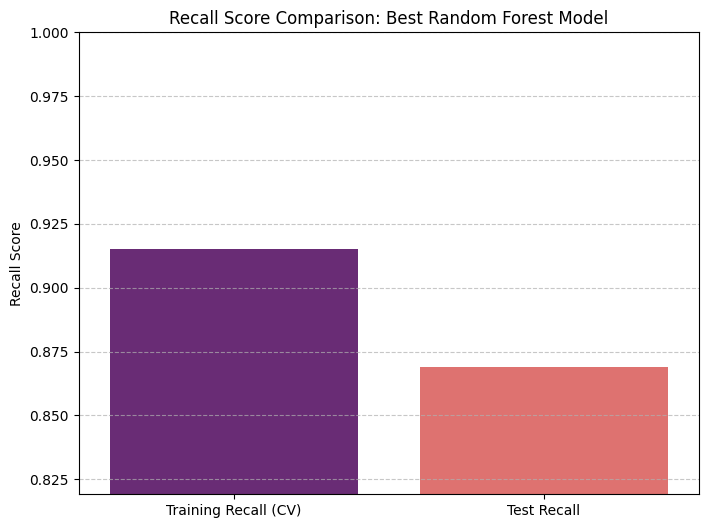

Training Recall (Cross-Validation): 0.9152
Test Recall: 0.8692

Observation: The training recall and test recall are close and relatively high, indicating a **good fit**.
The model generalizes well to unseen data, and there's a good balance between bias and variance.


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get the best recall score from CV (training performance)
train_recall_cv = tuned_rf['best_score']

# Get the test recall score of the best model (from previous evaluation)
test_recall = recall

# Create a DataFrame for plotting
data = {
    'Metric': ['Training Recall (CV)', 'Test Recall'],
    'Score': [train_recall_cv, test_recall]
}
recall_comparison_df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Score', data=recall_comparison_df, palette='magma', hue='Metric', legend=False)
plt.ylim(min(train_recall_cv, test_recall) - 0.05, 1.0) # Adjust y-axis for better visibility
plt.title(f'Recall Score Comparison: Best Random Forest Model')
plt.ylabel('Recall Score')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Training Recall (Cross-Validation): {train_recall_cv:.4f}")
print(f"Test Recall: {test_recall:.4f}")

if train_recall_cv > test_recall and (train_recall_cv - test_recall) > 0.05: # Threshold for significant difference
    print("\nObservation: The training recall is noticeably higher than the test recall, which suggests a degree of **overfitting**.")
    print("The model might be performing very well on the data it was trained on but generalizes slightly less effectively to new, unseen data.")
elif train_recall_cv < 0.7 or test_recall < 0.7: # Example threshold for 'low' performance
    print("\nObservation: Both training and test recall scores are relatively low, which might indicate **underfitting**.")
    print("The model might be too simple or not complex enough to capture the underlying patterns in the data.")
else:
    print("\nObservation: The training recall and test recall are close and relatively high, indicating a **good fit**.")
    print("The model generalizes well to unseen data, and there's a good balance between bias and variance.")

## Dataset Attributes Explained

Here's a breakdown of each attribute in the heart disease dataset, explaining its purpose, how it's measured, and its relevance:

*   **Age:**
    *   **Purpose/Role:** Represents the patient's age. Age is a significant demographic risk factor for various diseases, including heart disease.
    *   **Measurement:** Recorded in years.

*   **Sex:**
    *   **Purpose/Role:** Indicates the biological sex of the patient. Sex can influence disease prevalence, symptoms, and risk factors.
    *   **Measurement:** Categorical, with 'M' for Male and 'F' for Female.

*   **ChestPainType:**
    *   **Purpose/Role:** Describes the type of chest pain experienced by the patient. Different types of chest pain have varying implications for heart health.
    *   **Measurement:** Categorical:
        *   **TA:** Typical Angina (chest pain due to reduced blood flow to the heart).
        *   **ATA:** Atypical Angina (chest pain not typical of angina but still potentially cardiac).
        *   **NAP:** Non-Anginal Pain (chest pain not related to the heart).
        *   **ASY:** Asymptomatic (no chest pain symptoms, but may still have underlying heart disease).

*   **RestingBP (Resting Blood Pressure):**
    *   **Purpose/Role:** Measures the pressure of blood against artery walls when the heart is at rest. High resting blood pressure (hypertension) is a major risk factor for heart disease.
    *   **Measurement:** Numeric value, measured in millimeters of mercury (mm Hg).

*   **Cholesterol (Serum Cholesterol):**
    *   **Purpose/Role:** Refers to the level of cholesterol in the blood. High levels of certain types of cholesterol can lead to plaque buildup in arteries, increasing heart disease risk.
    *   **Measurement:** Numeric value, measured in milligrams per deciliter (mg/dl).

*   **FastingBS (Fasting Blood Sugar):**
    *   **Purpose/Role:** Indicates the patient's blood glucose level after a period of fasting. High fasting blood sugar is a marker for diabetes, which is a significant risk factor for heart disease.
    *   **Measurement:** Binary categorical:
        *   **1:** if Fasting Blood Sugar is greater than 120 mg/dl (indicating high sugar).
        *   **0:** otherwise (normal or low sugar).

*   **RestingECG (Resting Electrocardiogram Results):**
    *   **Purpose/Role:** Results from an electrocardiogram (ECG) performed while the patient is at rest. ECGs detect electrical activity of the heart and can reveal abnormalities that suggest heart conditions.
    *   **Measurement:** Categorical:
        *   **Normal:** Normal heart electrical activity.
        *   **ST:** Indicates ST-T wave abnormality (changes in the ECG waveform associated with myocardial ischemia).
        *   **LVH:** Shows probable or definite left ventricular hypertrophy (enlargement of the heart's main pumping chamber).

*   **MaxHR (Maximum Heart Rate Achieved):**
    *   **Purpose/Role:** The highest heart rate reached during an exercise stress test. A lower maximum heart rate for a given age can sometimes be an indicator of heart issues.
    *   **Measurement:** Numeric value, maximum heart rate is about 220 minus current age.

*   **ExerciseAngina (Exercise-Induced Angina):**
    *   **Purpose/Role:** Determines if chest pain (angina) is triggered by physical exertion. Angina that occurs with exercise is a strong symptom of coronary artery disease.
    *   **Measurement:** Binary categorical: 'Y' for Yes (angina induced) and 'N' for No (no angina induced).

*   **Oldpeak (ST Depression Induced by Exercise Relative to Rest):**
    *   **Purpose/Role:** A measure derived from an exercise ECG, representing the extent of ST segment depression during exercise compared to rest. Greater depression can indicate myocardial ischemia (reduced blood flow to the heart muscle).
    *   **Measurement:** Numeric value, measured in depression. Can be positive or negative.

*   **ST_Slope (Slope of the Peak Exercise ST Segment):**
    *   **Purpose/Role:** Describes the direction of the ST segment's slope on an exercise ECG. This is a key indicator of myocardial ischemia.
    *   **Measurement:** Categorical:
        *   **Up:** Upsloping (generally considered normal or less indicative of disease).
        *   **Flat:** Flat (suggests ischemia).
        *   **Down:** Downsloping (strongest indicator of ischemia).

*   **HeartDisease (Output Class):**
    *   **Purpose/Role:** The target variable indicating the presence or absence of heart disease in the patient.
    *   **Measurement:** Binary categorical:
        *   **1:** Presence of heart disease.
        *   **0:** Absence of heart disease (Normal).

These attributes collectively provide a comprehensive profile of a patient's cardiac health, allowing the machine learning model to identify patterns associated with heart disease.